# Toronto COVID-19 Cases Project

Author: Adrienne Siu
Date: August 2020

# 1. Problem Definition

In this project, I will use machine learning to:
(1) Predict the outcomes of cases of COVID-19 in Toronto
(2) Find the variables that correlate most with the outcome

The dataset is available on Toronto Open Data and the version from July 29, 2020 was used: https://open.toronto.ca/dataset/covid-19-cases-in-toronto/

This dataset has been saved as 'COVID19 cases.csv'.

The three possible outcomes are: fatal, resolved (not fatal), and active.

In [1]:
# DELETE
%qtconsole
import pdb
#import contextlib
#with contextlib.redirect_stdout(None):
#import pixiedust

#%%pixie_debugger
#pdb.set_trace()

# 2. Exploratory Data Analysis (EDA)

In this section, I will explore the data, including correlations between variables and outcomes.

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as mt

In [3]:
# Path of dataset file (.csv)
covid_file_path = 'COVID19 cases.csv'

# Read the file
covid_data = pd.read_csv(covid_file_path)

In [4]:
# Display the first few rows of the dataset
covid_data.head()

,_id,Assigned_ID,Outbreak Associated,Age Group,Neighbourhood Name,FSA,Source of Infection,Classification,Episode Date,Reported Date,Client Gender,Outcome,Currently Hospitalized,Currently in ICU,Currently Intubated,Ever Hospitalized,Ever in ICU,Ever Intubated
0,1,1,Sporadic,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,2020-01-22,2020-01-23,FEMALE,RESOLVED,No,No,No,No,No,No
1,2,2,Sporadic,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,2020-01-21,2020-01-23,MALE,RESOLVED,No,No,No,Yes,No,No
2,3,3,Sporadic,20 to 29 Years,Parkwoods-Donalda,M3A,Travel,CONFIRMED,2020-02-05,2020-02-21,FEMALE,RESOLVED,No,No,No,No,No,No
3,4,4,Sporadic,60 to 69 Years,Church-Yonge Corridor,M4W,Travel,CONFIRMED,2020-02-16,2020-02-25,FEMALE,RESOLVED,No,No,No,No,No,No
4,5,5,Sporadic,60 to 69 Years,Church-Yonge Corridor,M4W,Travel,CONFIRMED,2020-02-20,2020-02-26,MALE,RESOLVED,No,No,No,No,No,No


In [5]:
# Function to obtain filtered entries in dataset
# Input: column_name is a string for the name of the column, e.g. 'Outbreak', 'Age Group'
#        filter_column is a string for the column to be filtered
#        filter_entry is a string for the entry to be filtered
# Ex. To filter only the fatal outcomes, filter_column = 'Outcome' and filter_entry = 'FATAL'
# Returns entries and value counts for the specific column after filtering
def get_filtered_entries_and_value_counts_from_column(column_name, filter_column, filter_entry):
    # Get the count of each unique entry (ordered by name)
    entry_vc = covid_data[covid_data[filter_column]==filter_entry][column_name].value_counts() #.sort_index()
    # Get the unique entries and put them in a list
    entry = entry_vc.index.tolist()    
    return entry, entry_vc

In [6]:
# Function to create a bar chart of a column variable with filters applied
# Stack by outcome: active, fatal, resolved
# Input: column_name is a string for the name of the column, e.g. 'Outbreak', 'Age Group'
#        filter_column is a string for the column to be filtered
#        filter_entry_list is a list of strings for entries to be filtered
def create_filtered_bar_chart(column_name, filter_column, filter_entry_list, fig_size):
    # Initialize lists of entries and value counts after filtering
    entry_list = []
    entry_vc_list = []
    
    # Figure size
    if fig_size == 'large':
        fig = plt.figure(figsize=(20,30))
    else:
        fig = plt.figure()

    # Loop through entries to be filtered
    for i in range(len(filter_entry_list)):
        # Entries and value counts for each filter
        entry, entry_vc = get_filtered_entries_and_value_counts_from_column(column_name, filter_column, filter_entry_list[i])
        # Append to list
        entry_list.append(entry)
        entry_vc_list.append(entry_vc)
        # Create a bar stacked for each filtered entry, e.g. 'Fatal', 'Active', 'Resolved'
        plt.barh(entry_list[i], entry_vc_list[i])

    # Invert the y-axis so that the order of the entries is from top to bottom
    plt.gca().invert_yaxis()
    plt.title('Number of COVID-19 Cases By ' + column_name)
    plt.legend(filter_entry_list)
    plt.show()

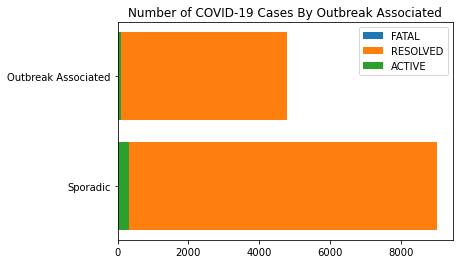

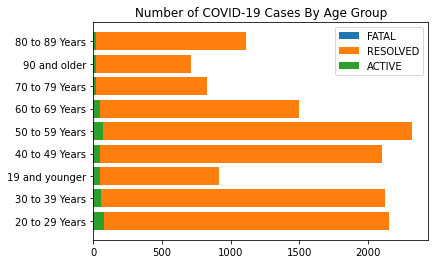

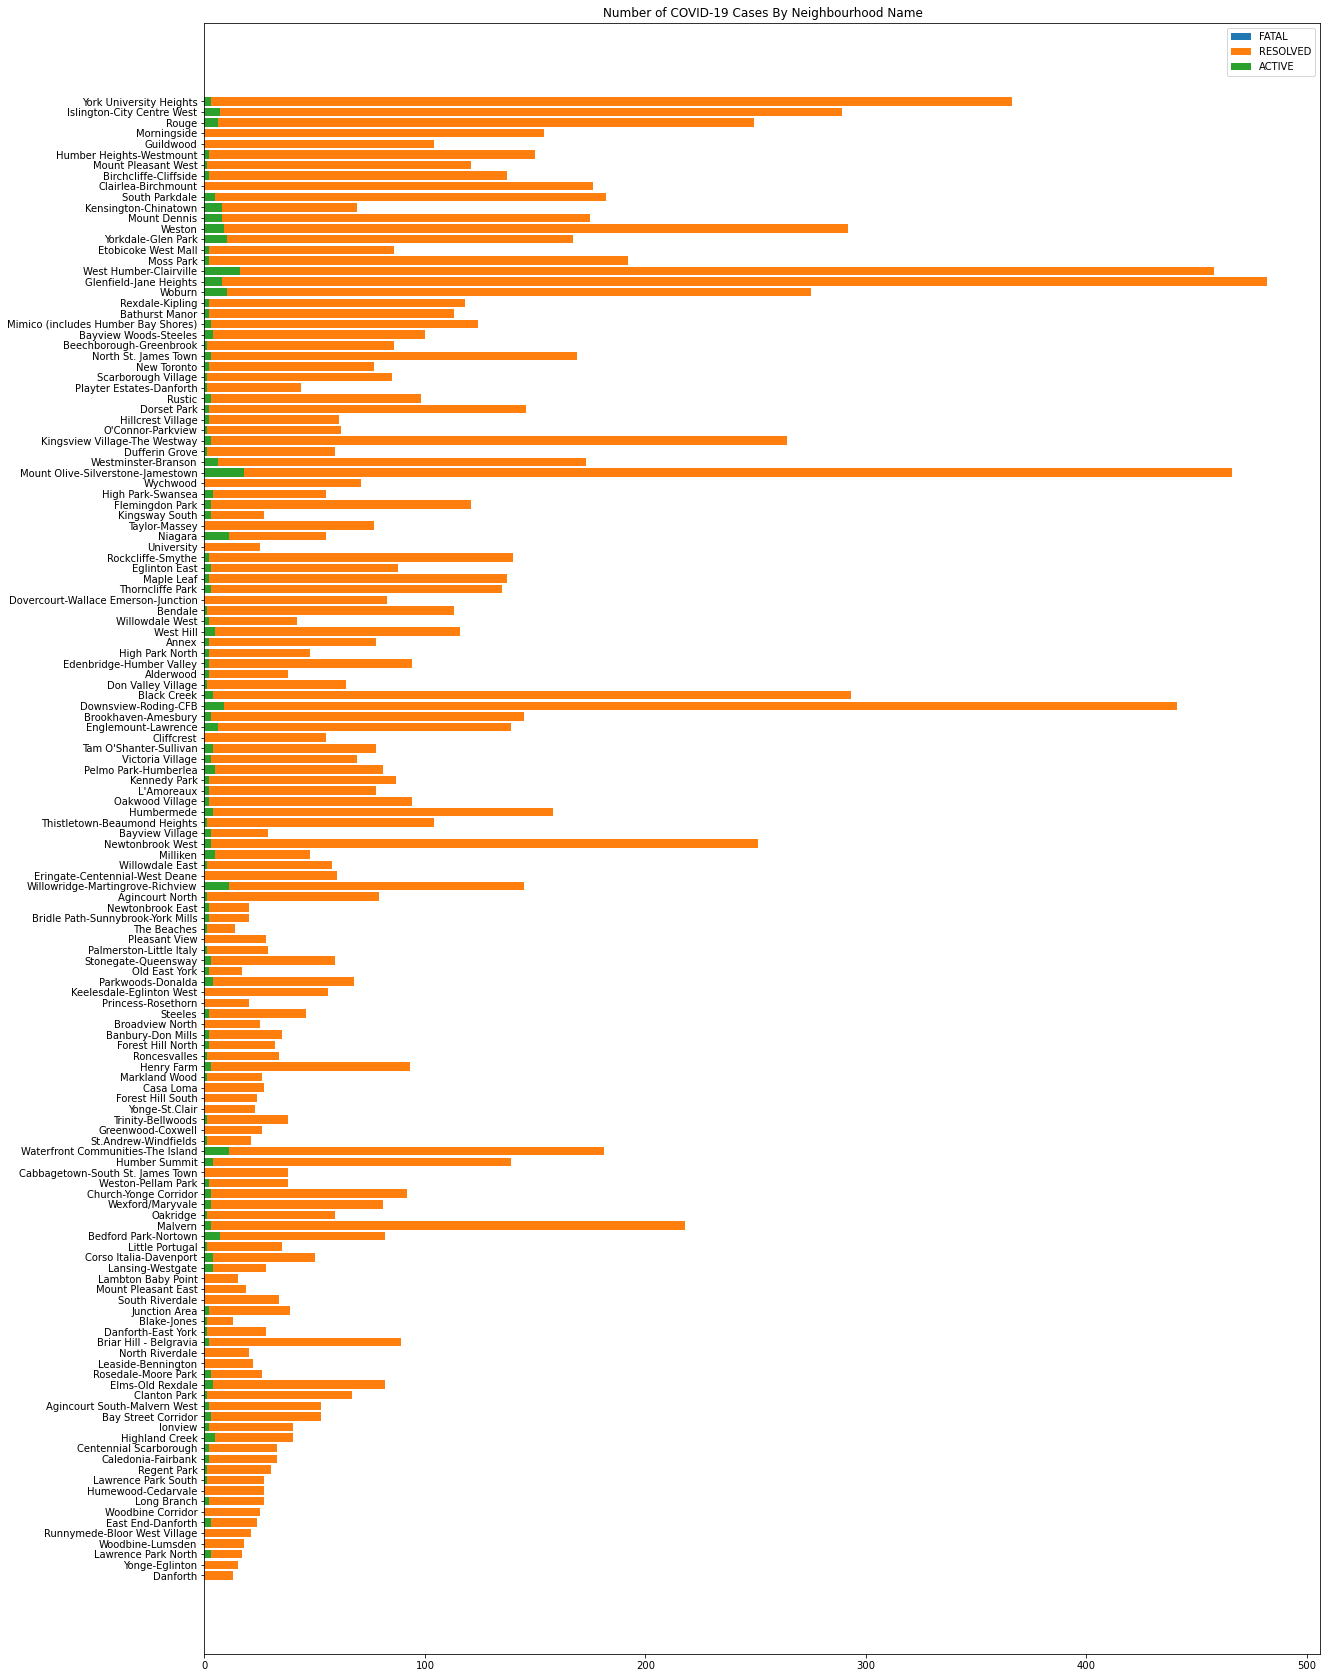

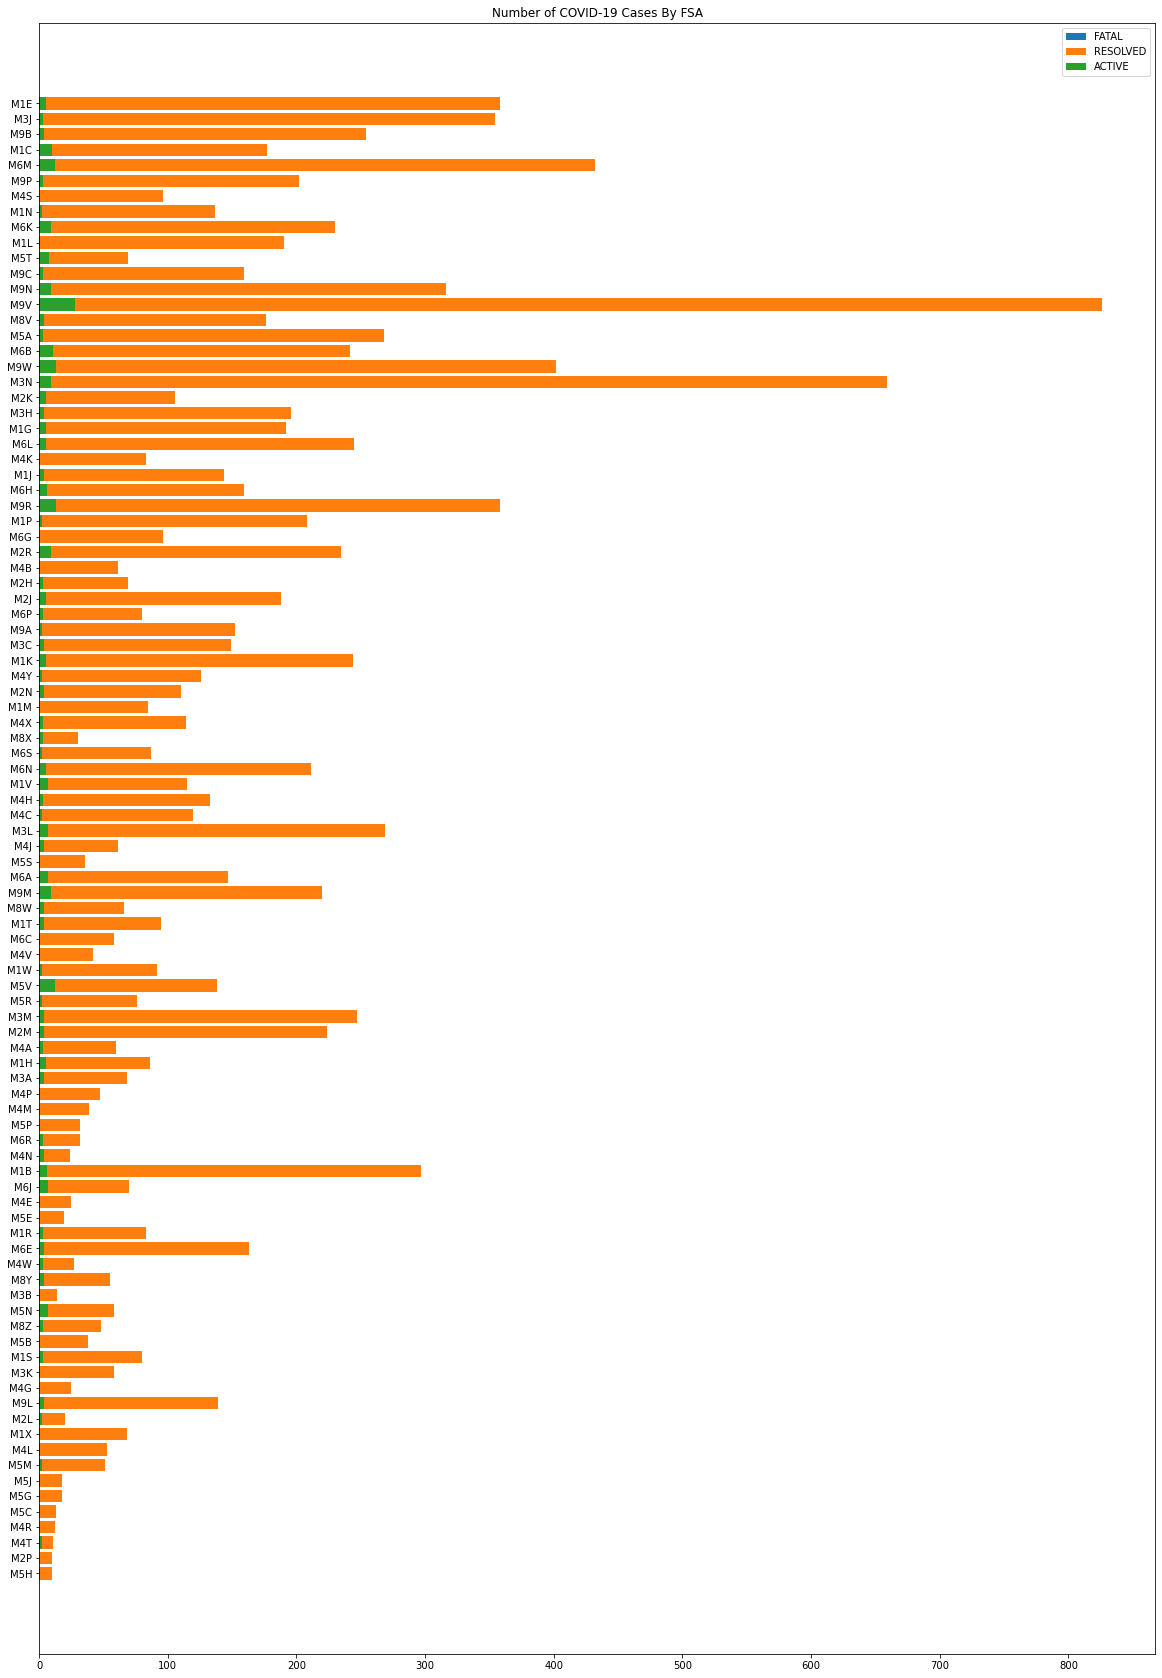

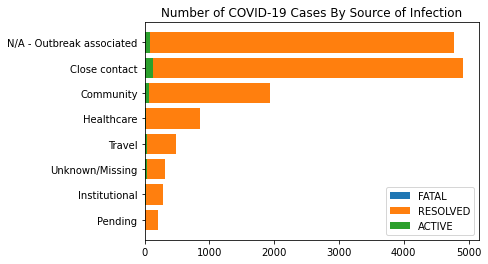

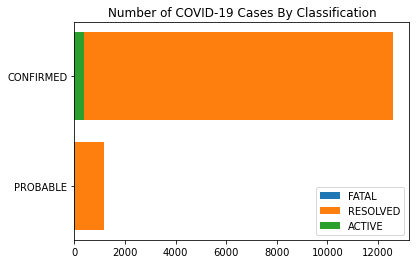

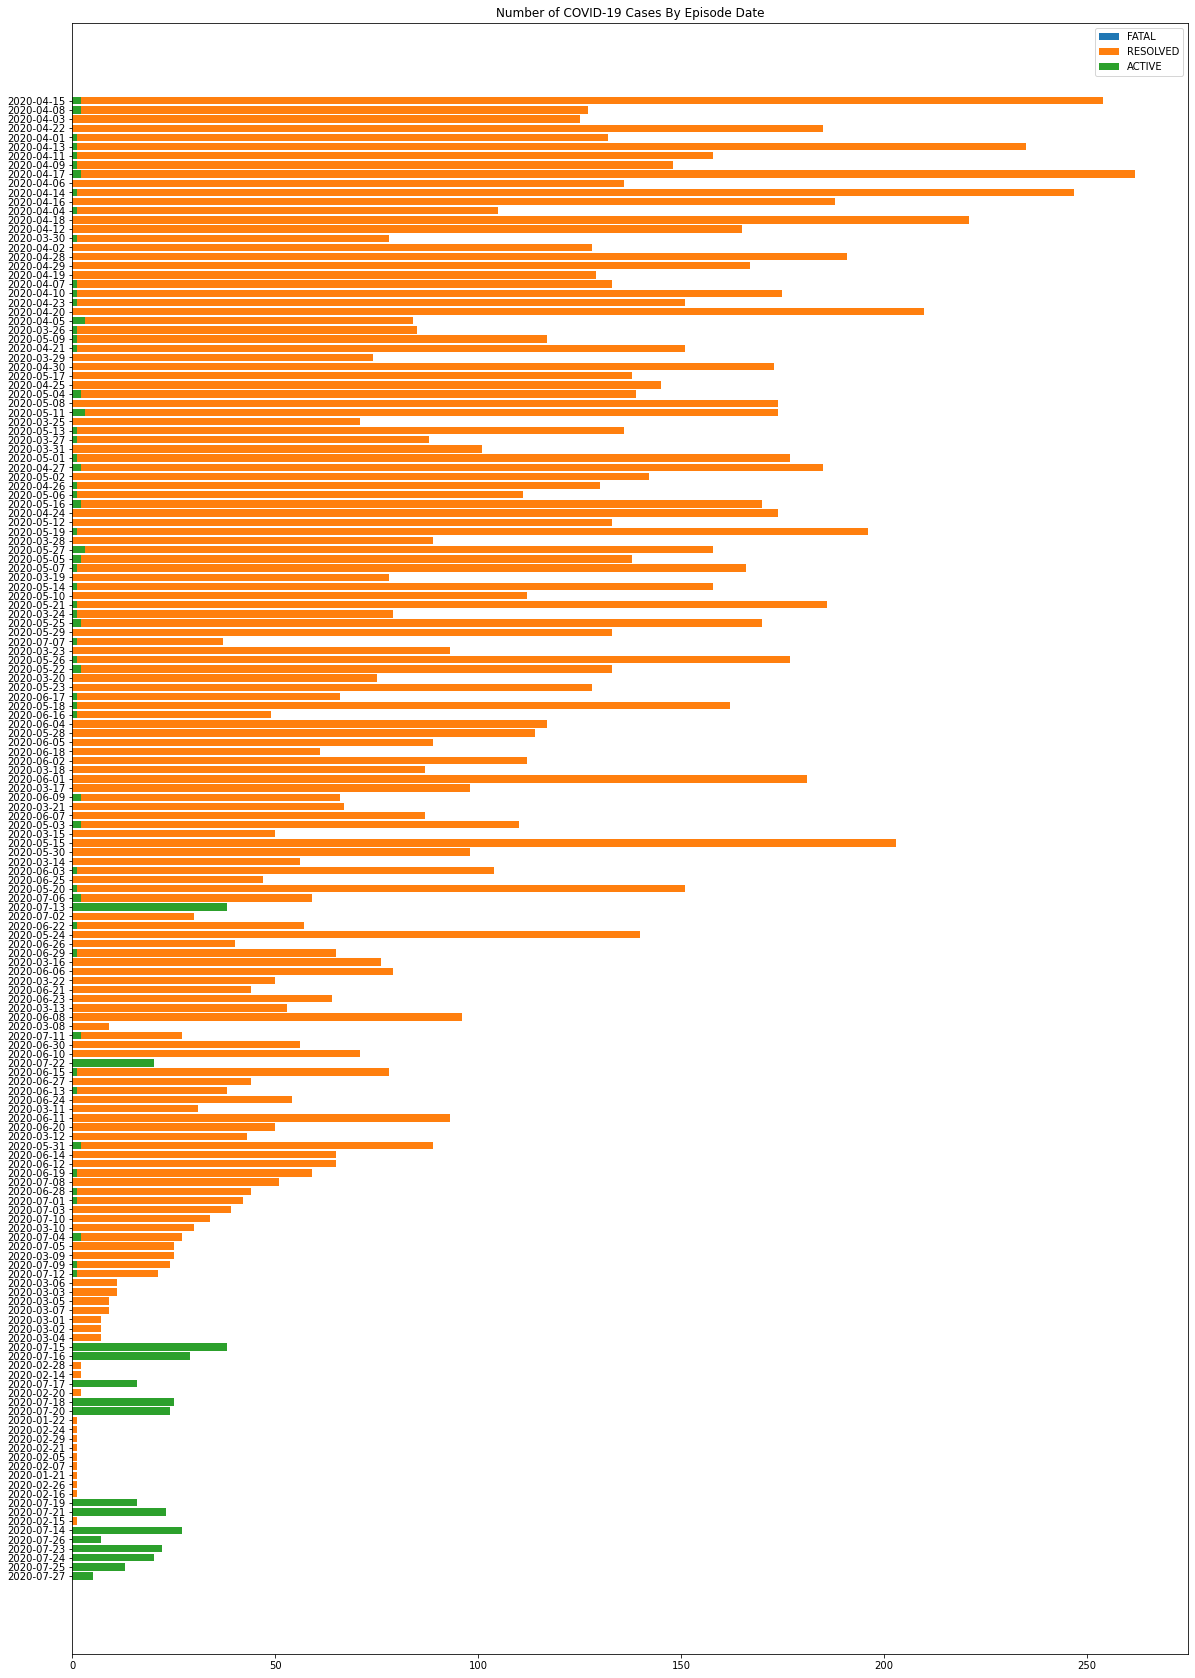

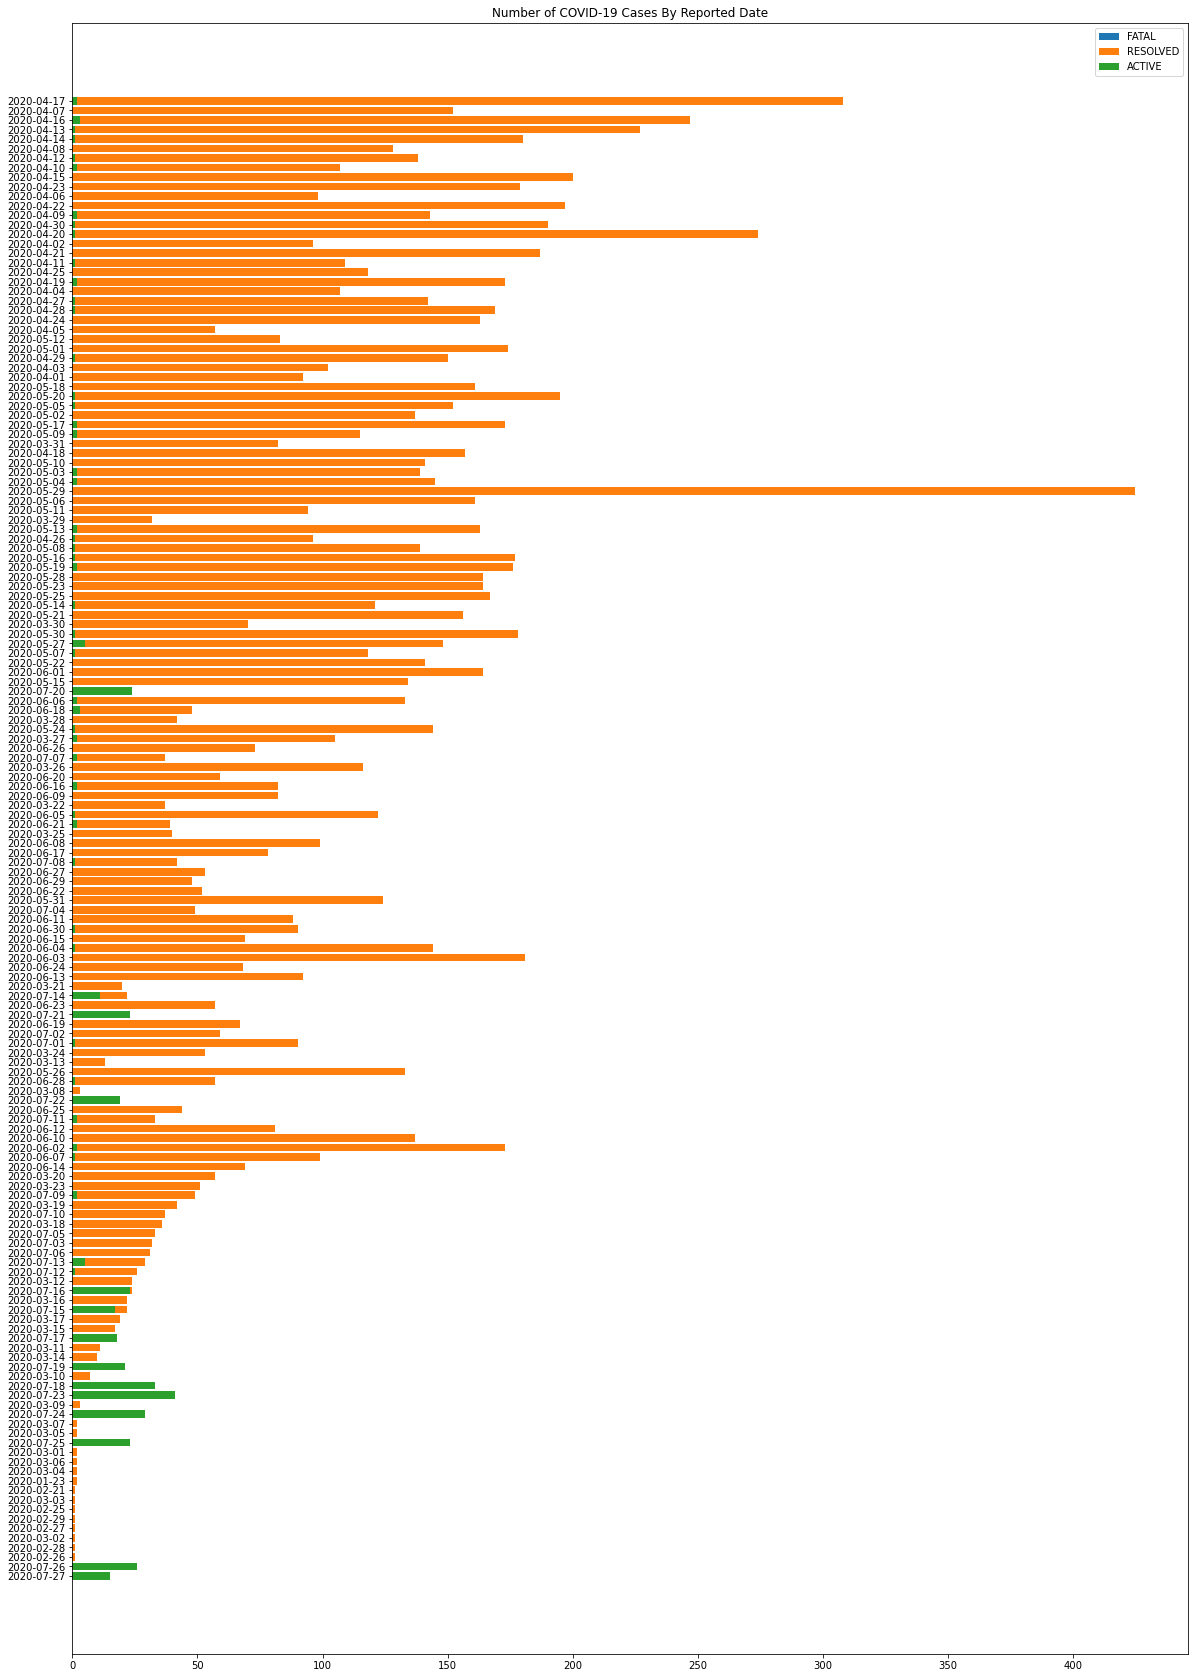

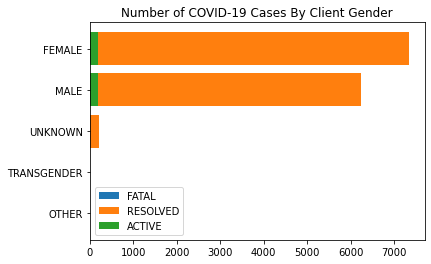

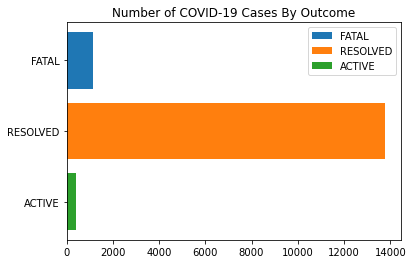

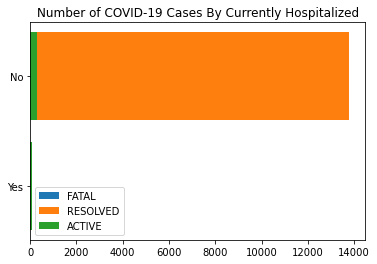

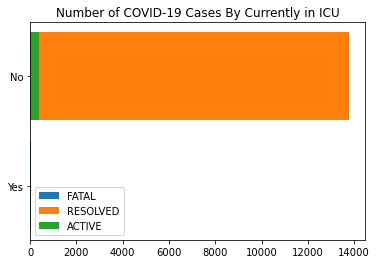

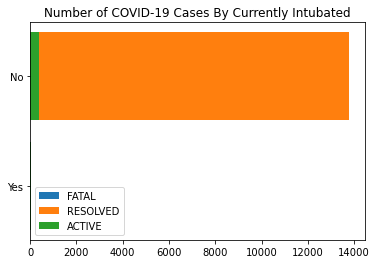

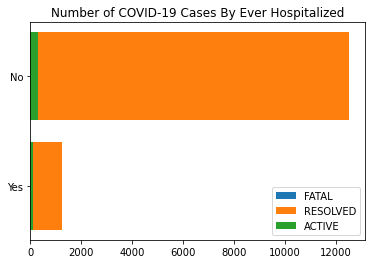

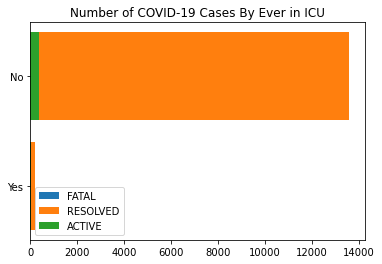

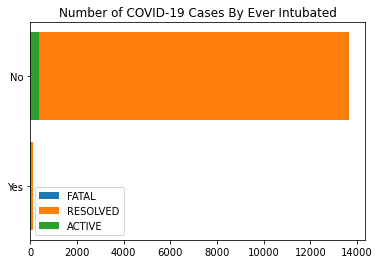

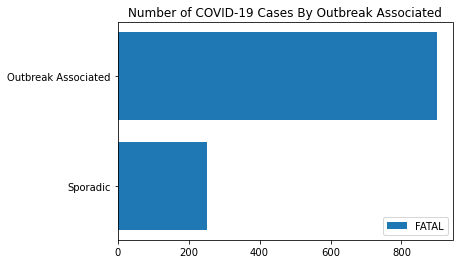

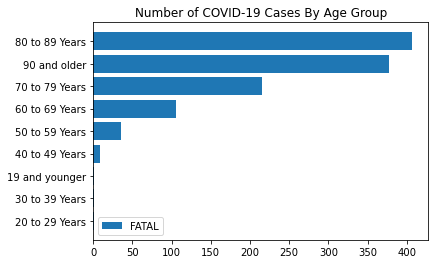

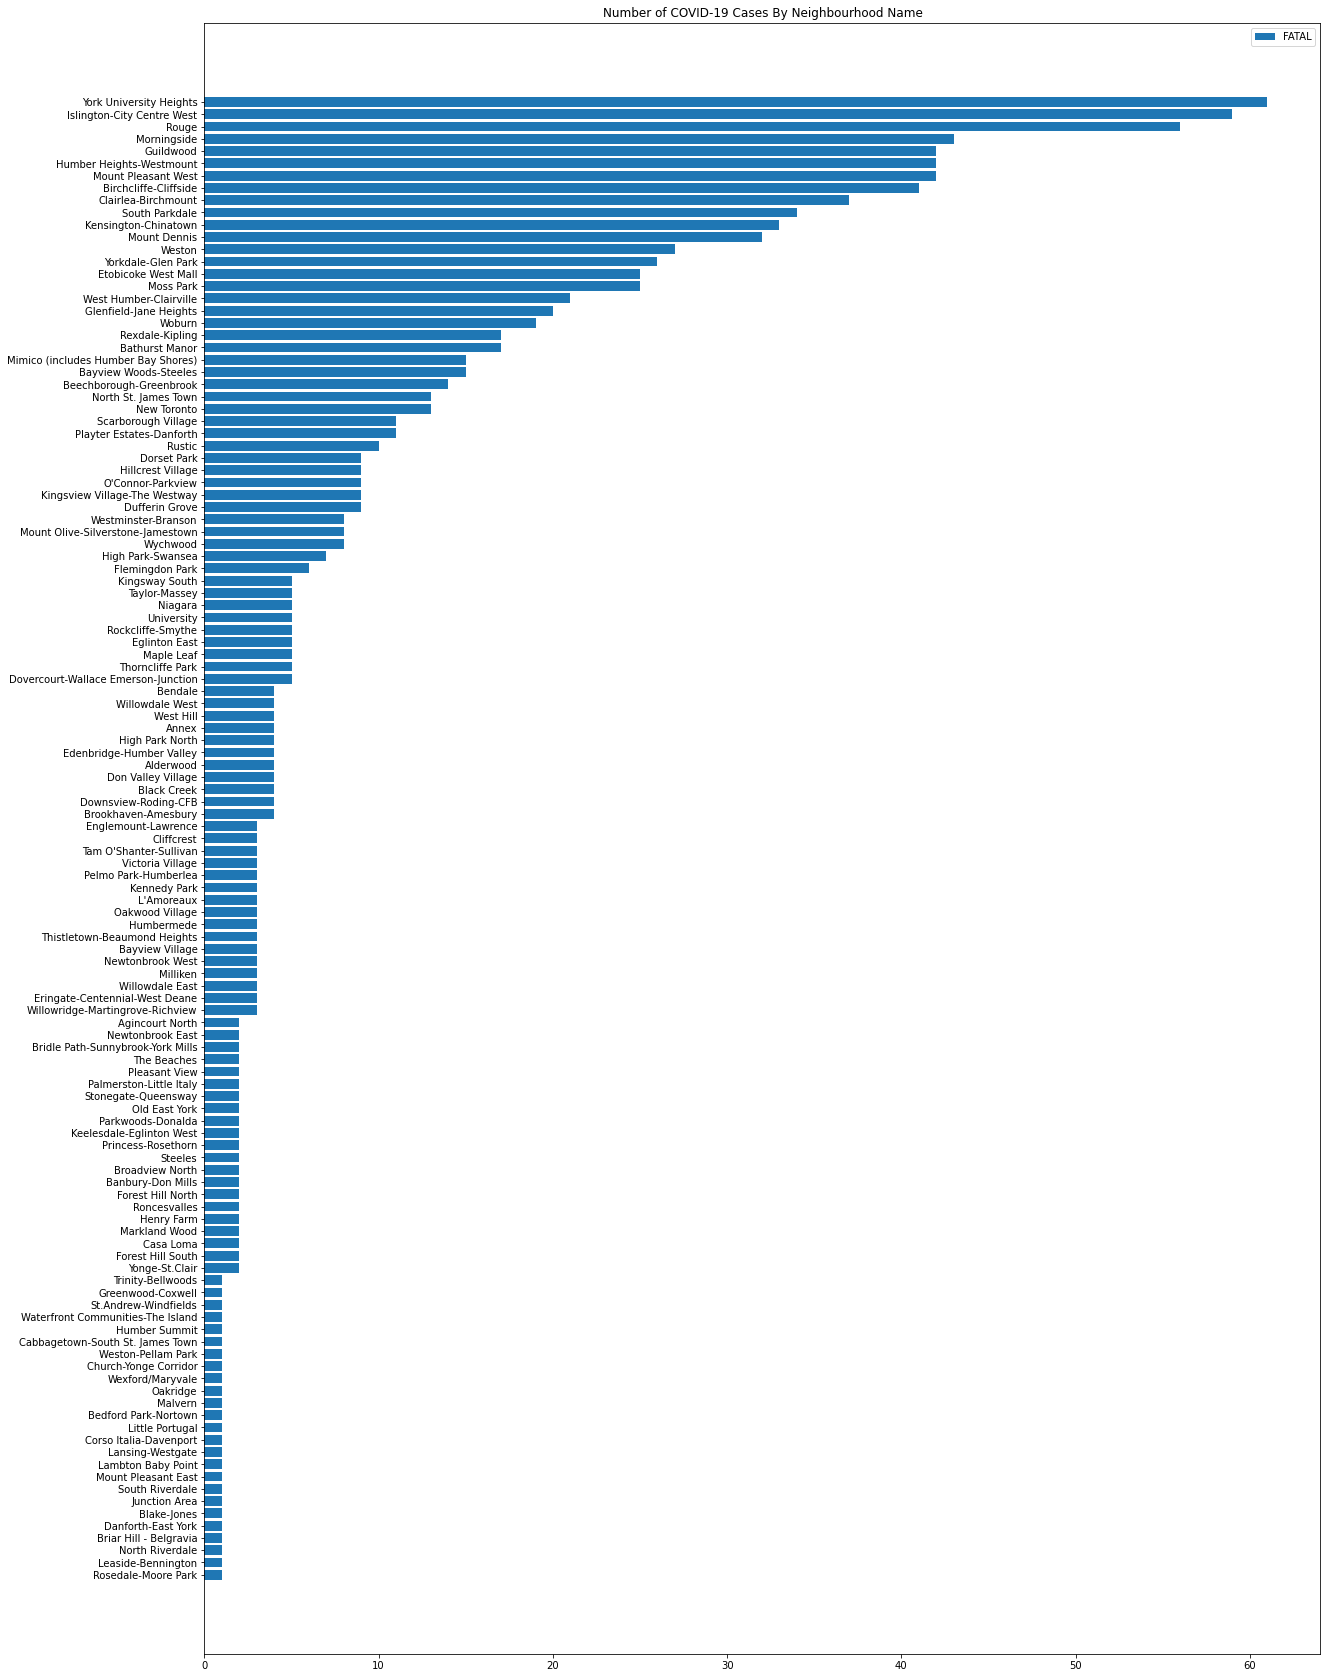

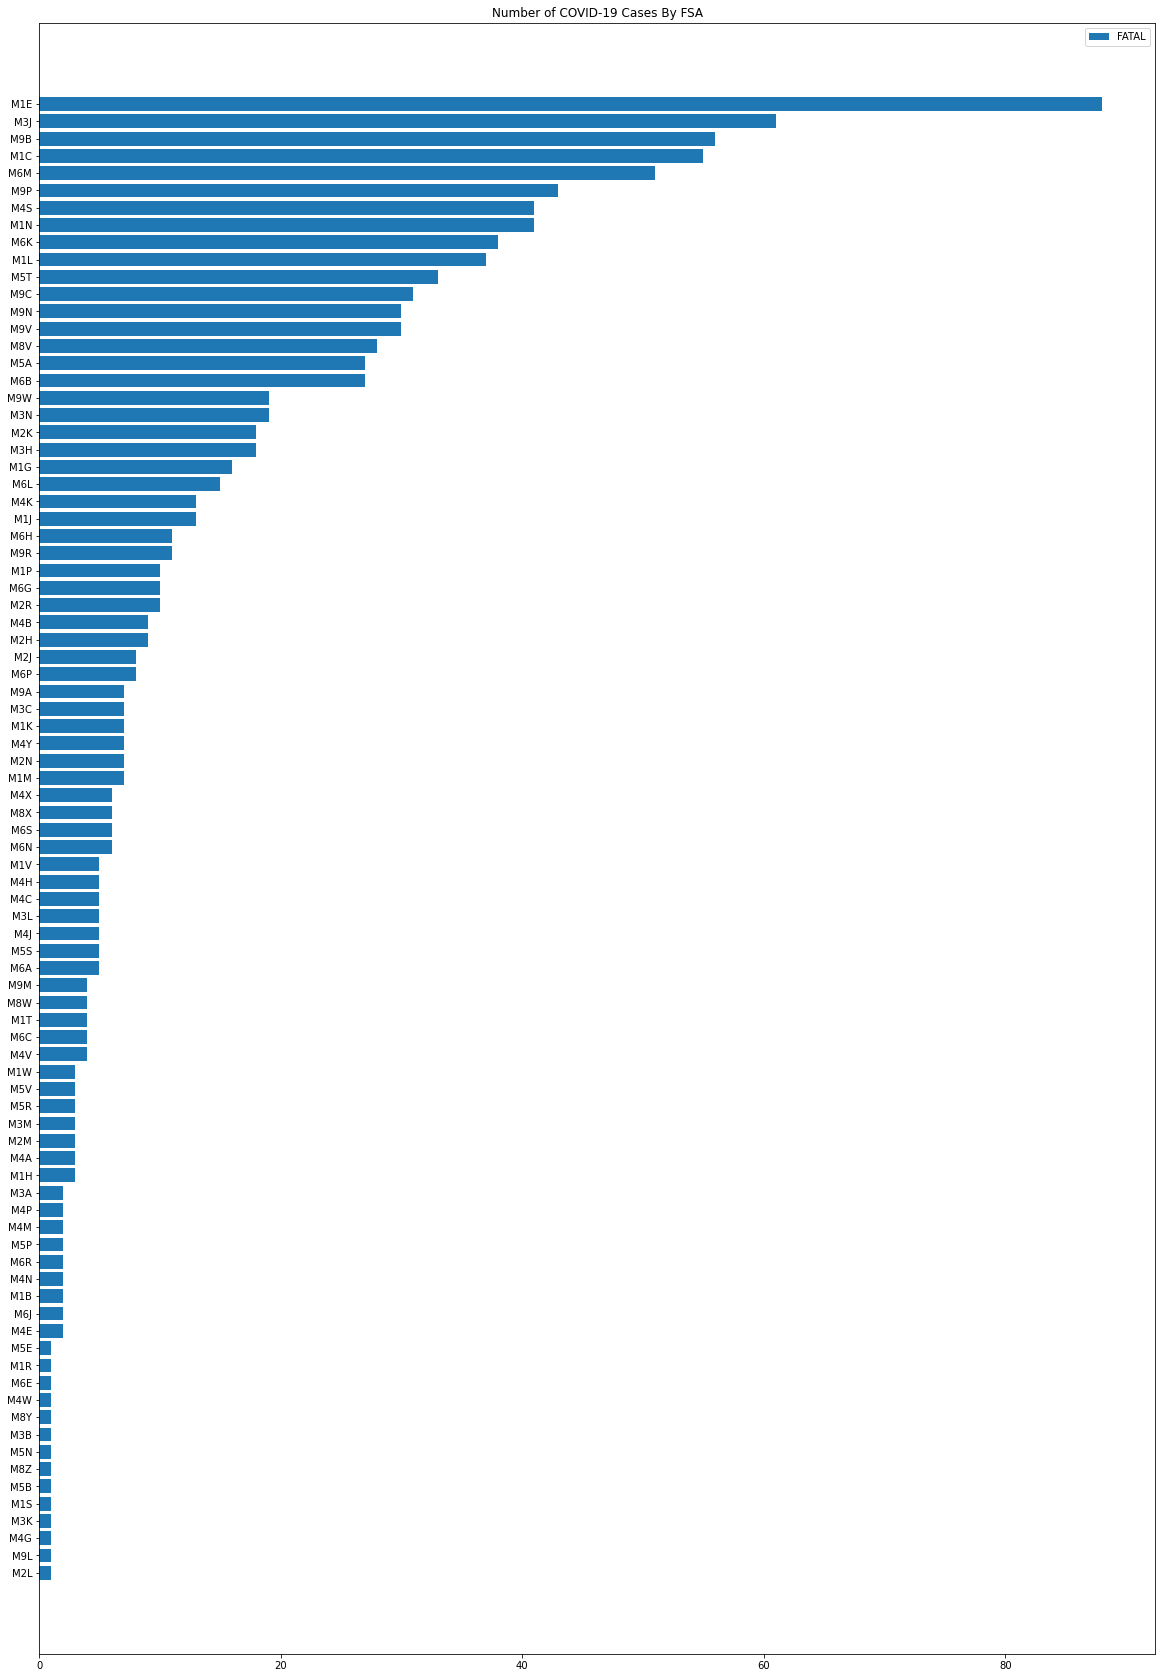

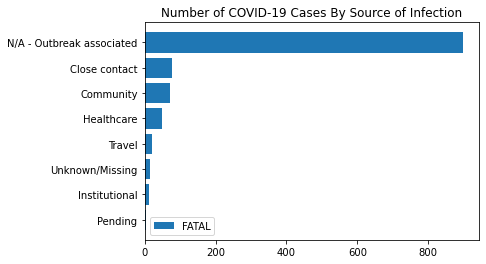

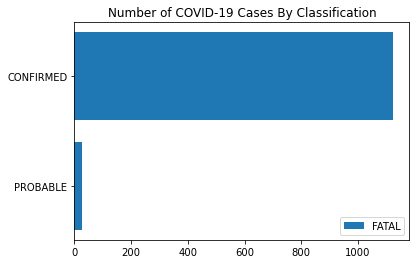

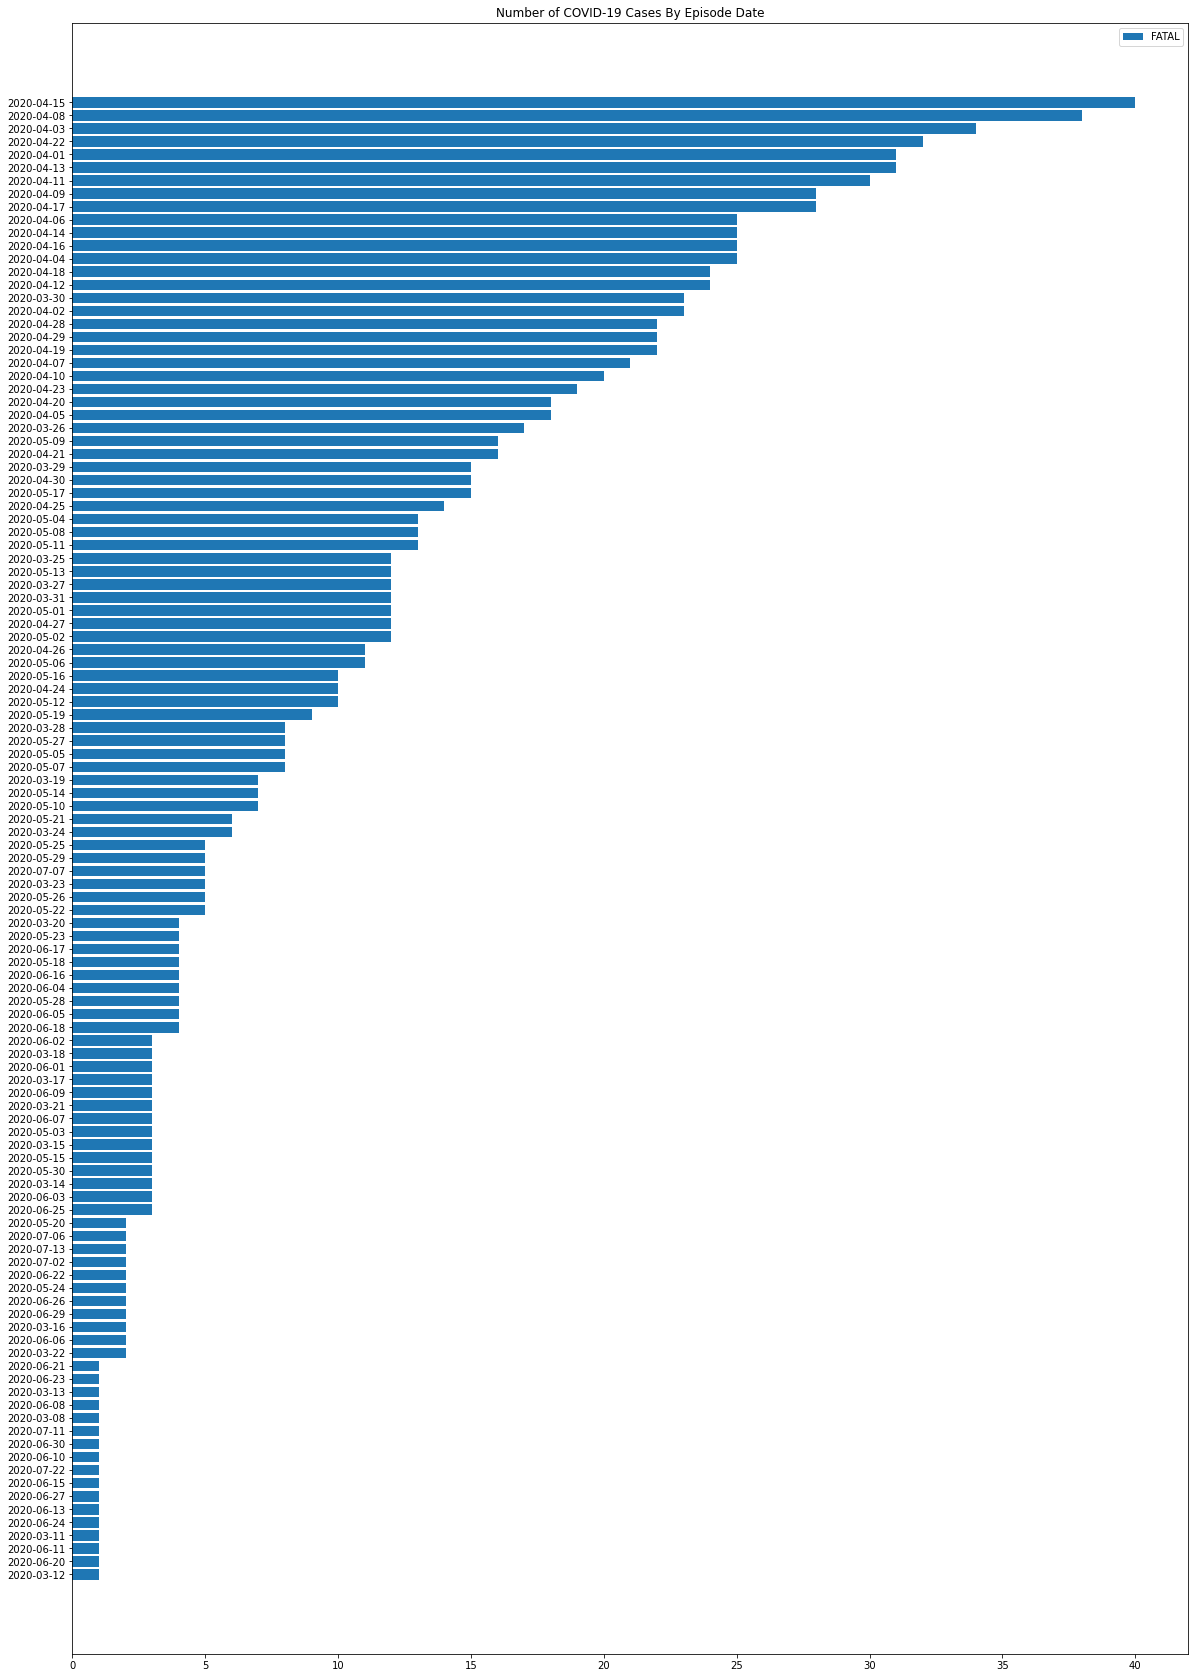

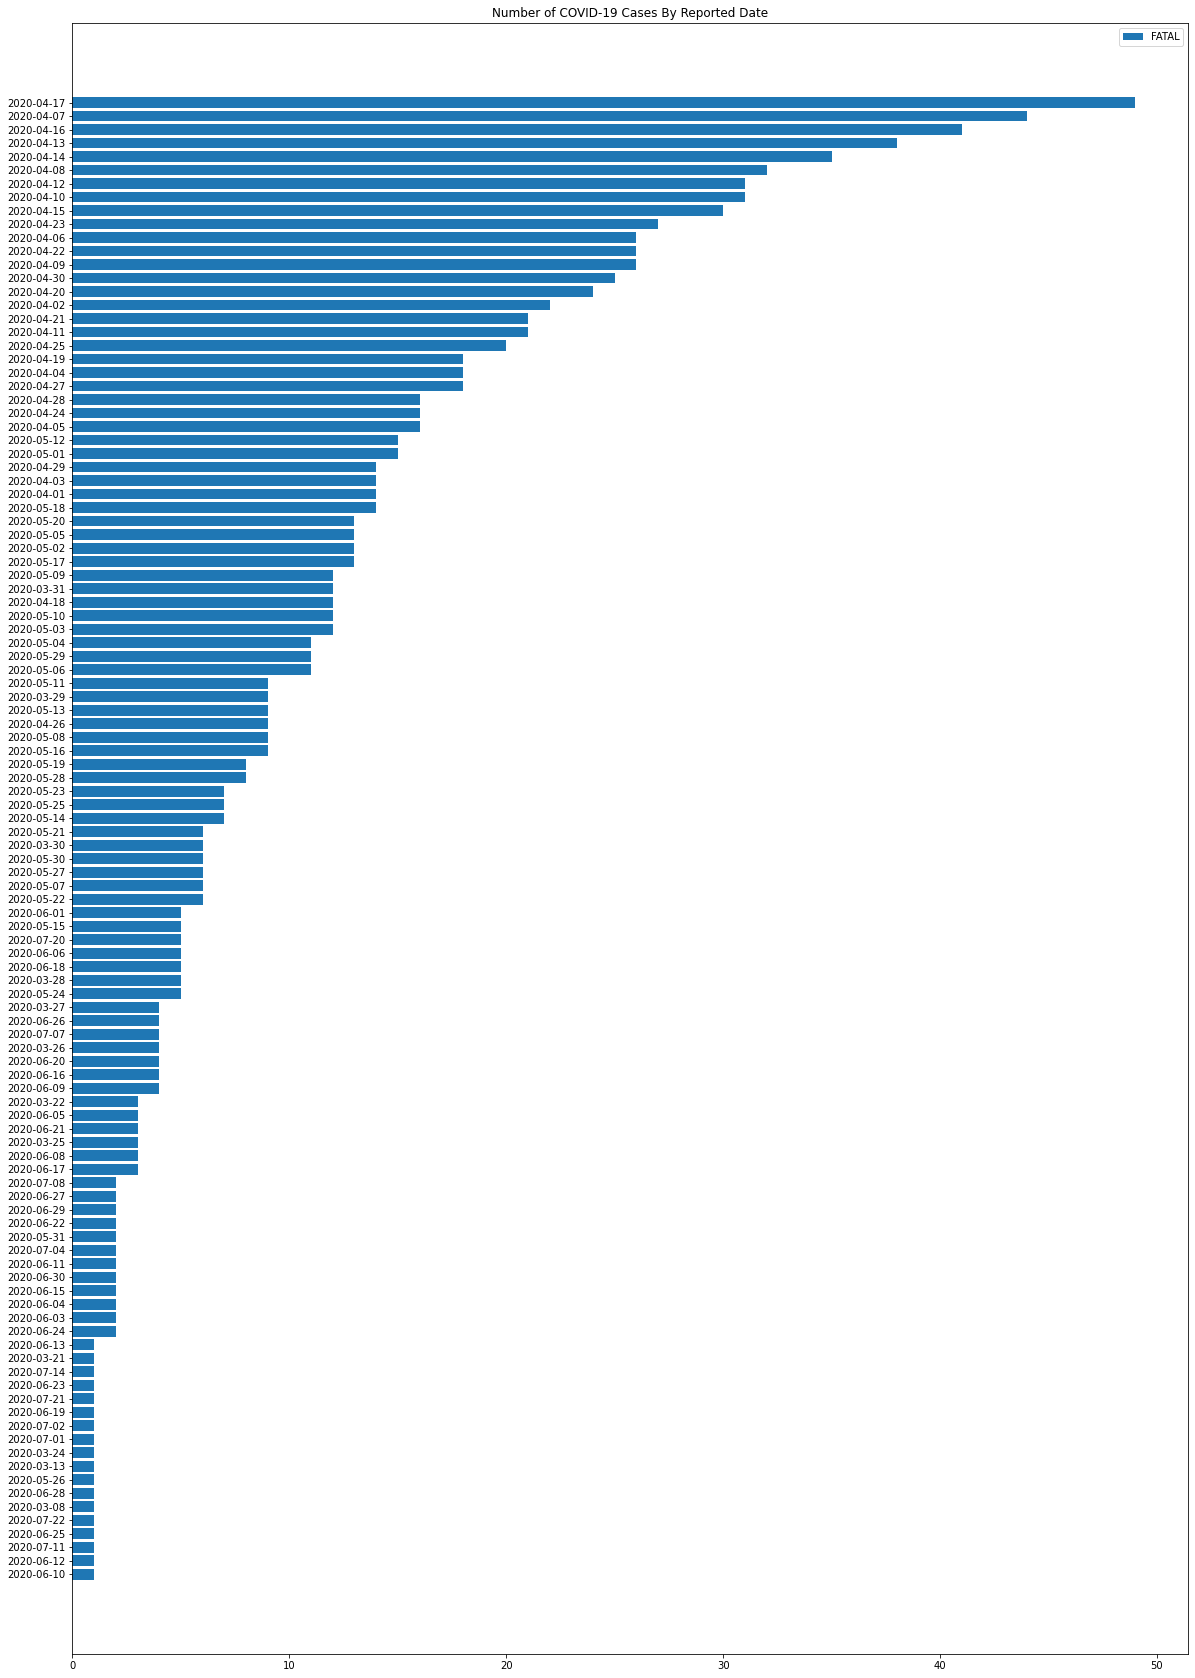

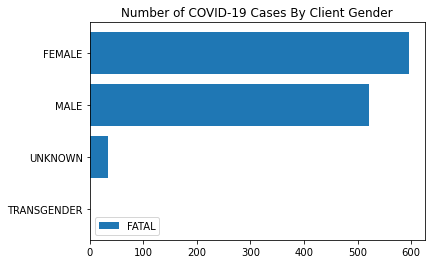

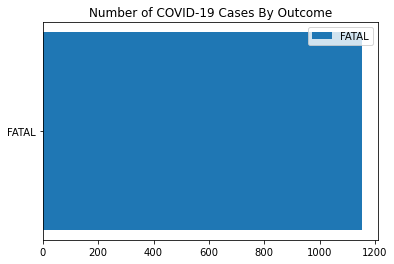

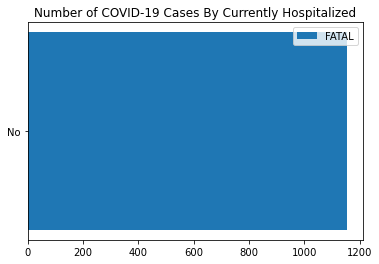

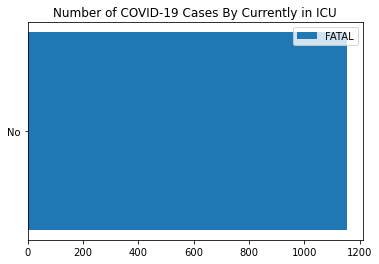

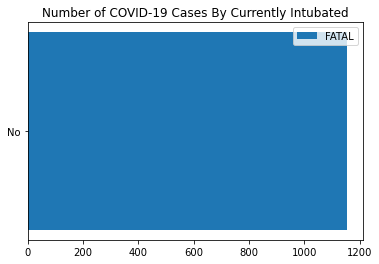

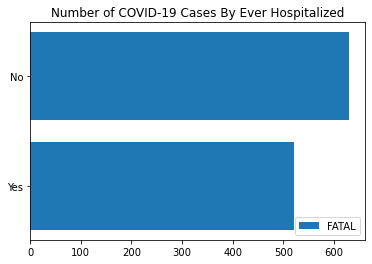

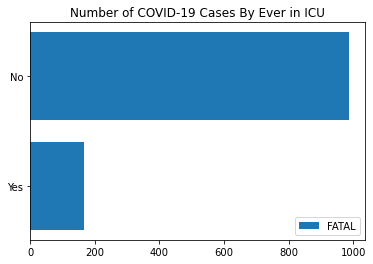

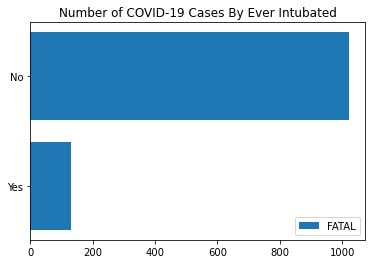

In [7]:
# Put the column names of the dataset into a list
columns = covid_data.columns

# Remove the first two column names (the IDs) because I don't need to graph them
columns_no_IDs = columns[2:]

# Column to be filtered
filter_column = 'Outcome'
# Entries to be filtered:
# First make stacked bar charts of all three outcomes, then bar charts of only fatal outcomes
filter_entry_list = [['FATAL', 'RESOLVED', 'ACTIVE'], ['FATAL']]

for j in range(len(filter_entry_list)):
    # Create bar charts for relevant columns
    for column in columns_no_IDs:
        #create_bar_chart(column)
        # Figure size
        if column == 'Neighbourhood Name' or column == 'FSA' or column == 'Episode Date' or column == 'Reported Date':
            fig_size = 'large'
        else:
            fig_size = 'normal'

        create_filtered_bar_chart(column, filter_column, filter_entry_list[j], fig_size)

The fatal cases make up 7.5% of total cases. As the number of resolved cases is an order of a magnitude higher, it is difficult to see the fatal cases in the bar charts. Hence, the fatal cases are graphed separately.

# 3. Data Cleaning

In this section, I will clean the data for analysis.

## Define training and validation sets

In [8]:
from sklearn.model_selection import train_test_split

# Target: outcome
y = covid_data.Outcome

# Predictor: drop _id and Assigned_ID columns
X = covid_data.drop(['_id', 'Assigned_ID'], axis=1)

# Split into training and validation sets (80/20 split)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [9]:
# Function to create a table of missing values in columns
# Function written by Nikos Tavoularis on Stack Overflow: https://stackoverflow.com/questions/26266362/how-to-count-the-nan-values-in-a-column-in-pandas-dataframe/39734251#39734251
# Function comments by AS
def missing_values_table(df):
        # Count the number of missing values in each column
        mis_val = df.isnull().sum()
        # Calculate the percentage of missing values in each column
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        # Put the number of missing values and % missing values in a table
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        # Rename the columns of the table
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        # Take out columns with no missing values
        # Reorder columns with missing values in descending order
        # Round % missing values to 1 decimal place
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        # Print summary
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        # Return table of missing values
        return mis_val_table_ren_columns

In [10]:
# Create table of missing values
missing_values_table(covid_data)

Your selected dataframe has 18 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
Neighbourhood Name,609,4.0
FSA,563,3.7
Age Group,27,0.2


As observed, there are only 3/18 columns with missing values. For each column, the % missing values is 4% or less. Hence, the dataset is fairly complete.

I will fill some of the missing values:

The age group will be filled with modal imputation, i.e. the modal age group.

If neither of the FSA or the neighbourhood name are known, these will remain unknown.

If the neighbourhood name is known but not the FSA, the FSA will be inferred.

In [11]:
# If both the neighbourhood and FSA are blank, find the modal FSA and neighbourhood name (as a pair)
# Note I am not using SimpleImputer because of the relationship between the neighbourhood name and FSA.
# If the modal neighbourhood name and modal FSA are treated separately as in SimpleImputer, the resulting pair
# of neighbourhood name and FSA could be impossible in real life.
# Input: dataset for imputation
# Output: modal FSA and neighbourhood name, sorted dataset
def find_mode_fsa_nn(data):
    # Group data by FSA and neighbourhood and count number of occurrences
    fsa_nn_group_data = data.groupby(['FSA', 'Neighbourhood Name'])['Outbreak Associated'].agg([len]).reset_index()
    # Sort from highest to lowest count (i.e. the mode is the first value)
    fsa_nn_group_data_sorted = fsa_nn_group_data.sort_values(by='len', ascending=False)
    # Find modal neighbourhood name and FSA
    mode_fsa = fsa_nn_group_data_sorted.iloc[0]['FSA']
    mode_nn = fsa_nn_group_data_sorted.iloc[0]['Neighbourhood Name']
    return mode_fsa, mode_nn, fsa_nn_group_data_sorted

# Impute missing values for the neighbourhood name and FSA
# Note there are no cases when the neighbourhood name is known but the FSA is blank
# Input: dataset, sorted dataset
def impute_missing_fsa_nn(data, mode_fsa, mode_nn, fsa_nn_group_data_sorted):
    # If an entry is blank, it is a 'NaN' and hence a float
    # If an entry is not blank, it is a string
    for i in data.index:
         # If both the neighbourhood name and FSA are blank
        if type(data['Neighbourhood Name'][i]) == float and type(data['FSA'][i]) == float:
            # Use the modal FSA and neighbourhood name
            data['FSA'][i] = mode_fsa
            data['Neighbourhood Name'][i] = mode_nn
            #print("Instance 1", i, data['FSA'][i], data['Neighbourhood Name'][i])

         # If the neighbourhood name is blank but the FSA is known
        if type(data['Neighbourhood Name'][i]) == float and type(data['FSA'][i]) != float:
            # Find the modal neighbourhood name for the given FSA
            # i.e. find the first instance of FSA in fsa_nn_group_data_sorted and its associated neighbourhood name
            mode_nn_for_fsa = fsa_nn_group_data_sorted.loc[fsa_nn_group_data_sorted['FSA'] == data['FSA'][i]].iloc[0]
            data['Neighbourhood Name'][i] = mode_nn_for_fsa
            #print("Instance 2", i, data['FSA'][i], data['Neighbourhood Name'][i])
    return data

In [12]:
# Make new copies of datasets
# y doesn't have any missing values, so imputation is not needed
X_train_imp_area = X_train
X_valid_imp_area = X_valid

# On the training set, return the mode FSA, mode neighbourhood name, and sorted training set
mode_fsa, mode_nn, fsa_nn_group_data_sorted = find_mode_fsa_nn(X_train_imp_area)

# Impute missing FSA and neighbourhood name values in the training set
X_train_imp_area = impute_missing_fsa_nn(X_train_imp_area, mode_fsa, mode_nn, fsa_nn_group_data_sorted)

# Impute missing FSA and neighbourhood name values in the validation set based on the modes
# in the training set
X_valid_imp_area = impute_missing_fsa_nn(X_valid_imp_area, mode_fsa, mode_nn, fsa_nn_group_data_sorted)

<ipython-input-12-4a57e13add3d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_imp_area = impute_missing_fsa_nn(X_train_imp_area, mode_fsa, mode_nn, fsa_nn_group_data_sorted)
<ipython-input-12-4a57e13add3d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_imp_area = impute_missing_fsa_nn(X_valid_imp_area, mode_fsa, mode_nn, fsa_nn_group_data_sorted)


In [13]:
# TEST!!!
# Age group: modal imputation
from sklearn.impute import SimpleImputer

X_train_test = X_train_imp_area.applymap(str) #drop(['FSA'], axis=1)
X_valid_test = X_valid_imp_area.applymap(str) #drop(['FSA'], axis=1)

# Imputer with most_frequent (modal) strategy
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent', verbose=1)
#pdb.set_trace()
X_train_imp_age = pd.DataFrame(imputer.fit_transform(X_train_test)) #_imp_area))
X_valid_imp_age = pd.DataFrame(imputer.transform(X_valid_test)) #_imp_area))

# Rename columns
X_train_imp_age.columns = X_train_imp_area.columns
X_valid_imp_age.columns = X_valid_imp_area.columns

print('Done')

Done


In [14]:
X_train_imp_area.to_excel("X_train_imp_area.xlsx")
X_valid_imp_area.to_excel("X_valid_imp_area.xlsx")

In [15]:
# # Age group: modal imputation
# from sklearn.impute import SimpleImputer

# # Imputer with most_frequent (modal) strategy
# imputer = SimpleImputer(strategy='most_frequent')
# X_train_imp_new = pd.DataFrame(imputer.fit_transform(X_train_imp_area))
# X_valid_imp_new = pd.DataFrame(imputer.transform(X_valid_imp_area))

# # Rename columns
# X_train_imp_new.columns = X_train_imp_area.columns
# X_valid_imp_new.columns = X_valid_imp_area.columns


# 4. Feature Selection and Engineering

Feature selection will involve:
-Removing the _id and Assigned_ID columns

Feature engineering will involve:
-Label encoding the Age Group, Episode Date, and Reported Date columns
-One-hot encoding the other columns

Note that one-hot encoding the Neighbourhood Name and FSA columns will yield sparse data. We will see how the models fare...

In [16]:
# Look for categorical variables
covid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15338 entries, 0 to 15337
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   _id                     15338 non-null  int64 
 1   Assigned_ID             15338 non-null  int64 
 2   Outbreak Associated     15338 non-null  object
 3   Age Group               15311 non-null  object
 4   Neighbourhood Name      14729 non-null  object
 5   FSA                     14775 non-null  object
 6   Source of Infection     15338 non-null  object
 7   Classification          15338 non-null  object
 8   Episode Date            15338 non-null  object
 9   Reported Date           15338 non-null  object
 10  Client Gender           15338 non-null  object
 11  Outcome                 15338 non-null  object
 12  Currently Hospitalized  15338 non-null  object
 13  Currently in ICU        15338 non-null  object
 14  Currently Intubated     15338 non-null  object
 15  Ev

Apart from the patient ID, the columns are all categorical variables. I will deal with encoding for categorical variables in the modelling section.